# Robustly Optimized BERT Pretraining Approach (RoBERTa) Notebook

```md
@authors: Grupo 03
```

In [9]:
# Notebook Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import tensorflow as tf
import shutil
import random

from tensorflow import keras
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from enum import Enum

In [10]:
# Model run enum
class ModelRunMode(Enum):
    """
    Enumeration of Model Run Mode.
    """
    TRAIN           = "train"           # Train Mode
    CLASSIFY        = "classify"        # Classify Mode

In [11]:
# Model run mode
# Options: 
#   ModelRunMode.TRAIN.value            (Train the model)
#   ModelRunMode.CLASSIFY.value         (Classify data)
mode = ModelRunMode.TRAIN.value
# Prefix for saving the model files
model_prefix = "llm_roberta_model"
file_path = "llm_roberta_model_weights"
separator_char = "\t"

In [12]:
# Parameters cell
if mode == ModelRunMode.TRAIN.value:
    # TRAIN mode: Set parameters for training
    input_csv = "../tarefa_1/test_input_dataset/merged_inputs.csv"                                  # CSV file with training inputs (ID, Text)
    output_csv = "../tarefa_1/test_output_dataset/merged_outputs.csv"                               # CSV file with training outputs (ID, Label)
    test_size = 0.3                                                                                 # Proportion of the dataset to use as test data
    random_state=42                                                                                 # Seed for reproducible dataset splitting
    seed = 42                                                                                       # Global seed for reproducibility across Python, NumPy, and TensorFlow
    os.environ['PYTHONHASHSEED'] = str(seed)                                                        # Set environment variable for Python's internal hash seed for determinism
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"                                                      # Attempt to force cuDNN to be deterministic
    random.seed(seed)                                                                               # Set Python's built-in random module seed
    np.random.seed(seed)                                                                            # Set NumPy random seed
    tf.random.set_seed(seed)                                                                        # Set TensorFlow random seed
elif mode == ModelRunMode.CLASSIFY.value:
    # CLASSIFY mode: Set parameters for classification
    input_csv = "../tarefa_3/classify_input_datasets/submission3_inputs.csv"                        # CSV file with texts for prediction (ID, Text)
    output_csv = "../tarefa_3/classify_output_datasets/submission3_outputs_llm_roberta_model.csv"   # CSV file to store prediction result
else:
    print("The selected option is not valid. Options: \"train\" or \"classify\"!")
    SystemExit()

In [13]:
# Method to load and merge two datasets by ID column
def merge_data_by_id(input_csv, output_csv, sep="\t"):
    df_in = pd.read_csv(input_csv, sep=sep)
    df_out = pd.read_csv(output_csv, sep=sep)

    # Remove duplicates or NaNs if needed
    df_in.dropna(subset=["ID", "Text"], inplace=True)
    df_out.dropna(subset=["ID", "Label"], inplace=True)
    df_in.drop_duplicates(subset=["ID"], inplace=True)
    df_out.drop_duplicates(subset=["ID"], inplace=True)

    df_merged = pd.merge(df_in, df_out, on="ID", how="inner")
    return df_merged

# Method for text cleaning
def text_cleaning(text):
        # Remove URLs
        text = re.sub(r'http[s]?://\S+', "", text)
        # Remove HTML tags
        text = re.sub(r"<[^>]*>", "", text)
        # Remove common LaTeX commands
        text = re.sub(r"\\[a-zA-Z]+(\{.*?\})?", "", text)
        # Remove email addresses
        text = re.sub(r'\S+@\S+', "", text)
        # Return cleaned text
        return text

# Method to convert labels to binary
def convert_labels_to_binary_and_text(df_merged):
    df_merged["Label"] = df_merged["Label"].str.lower().str.strip()
    y = np.where(df_merged["Label"] == "ai", 1, 0)
    texts = df_merged["Text"].tolist()
    return y, texts

# Method to plot the learning curves
def plot_learning_curves(history):
    # Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

# Method to check label distribution
def check_label_distribution(df_merged):
    label_counts = df_merged["Label"].value_counts(dropna=False)
    print("Label distribution:\n", label_counts)

# Method to print the first 5 cleaned texts
def debug_text_cleaning(df_merged):
    for i in range(min(5, len(df_merged))):
        print(df_merged["Text"].iloc[i])

In [14]:
# BERT Model training function
def train_roberta(input_csv, output_csv, model_ckpt="roberta-base", output_dir=file_path, model_prefix= model_prefix, num_train_epochs=3, batch_size=8, test_size=0.2, learning_rate=1e-3, random_state=48):
    # Load data
    df_merged = merge_data_by_id(input_csv, output_csv, sep=separator_char)

    # Check label distribution
    check_label_distribution(df_merged=df_merged)

    # Text cleaning
    df_merged["Text"] = df_merged["Text"].apply(text_cleaning)

    # Print the first 5 cleaned texts
    debug_text_cleaning(df_merged)

    # Convert label/text
    labels, texts = convert_labels_to_binary_and_text(df_merged)

    # Split entire dataset into train_val vs test
    X_train_texts, X_val_texts, y_train, y_val = train_test_split(texts, labels, test_size=test_size, random_state=random_state, stratify=labels)

    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    # Tokenize without truncation/padding to compute lengths
    raw_train_encodings = tokenizer(X_train_texts, add_special_tokens=True, truncation=False, padding=False)
    token_lengths = [len(seq) for seq in raw_train_encodings["input_ids"]]

    # Calculate max_length based on the 90th percentile
    max_length = int(np.percentile(token_lengths, 90))

    # Tokenize with truncation and padding using the calculated max_length
    train_encodings = tokenizer(X_train_texts, truncation=True, padding="max_length", max_length=max_length)
    val_encodings = tokenizer(X_val_texts, truncation=True, padding="max_length", max_length=max_length)

    # Convert to tf.data.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))

    # Batch the datasets
    train_dataset = train_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    # Load the model & set high dropout rates for regularization
    model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)
    model.config.hidden_dropout_prob = 0.4
    model.config.attention_probs_dropout_prob = 0.3
    
    # Learning rate schedule & optimizer
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=1000,
        decay_rate=0.5,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    # Label smoothing in the loss function
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    
    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
    
    # Train
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_train_epochs,
        callbacks=[early_stopping]
    )

    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(val_dataset)
    print(f"\nValidation Accuracy: {val_acc:.4f} | Validation Loss: {val_loss:.4f}")

    # Display model sumary
    model.summary()

    # Plot training curves
    plot_learning_curves(history)

    # Get predictions from the best model on the validation set
    outputs = model.predict(val_dataset)

    if isinstance(outputs, dict) and "logits" in outputs:
        logits = outputs["logits"]
    else:
        logits = outputs
    
    # Convert logits to probabilities
    probs = tf.nn.sigmoid(logits[:, 1]).numpy()
    
    # Threshold => "AI" vs "Human"
    pred_bin = (probs >= 0.5).astype(int)

    # Calculate the F1 score
    f1 = f1_score(y_val, pred_bin)

    # Calculate the recall score
    recall = recall_score(y_val, pred_bin)

    # Calculate the precision score
    precision = precision_score(y_val, pred_bin)

    # Compute the confusion matrix
    cm = confusion_matrix(y_val, pred_bin)

    # Print the calculated metrics
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print("Confusion Matrix:\n", cm)

    # If the output_dir already exists, remove it entirely
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    # Now recreate the folder
    os.makedirs(output_dir, exist_ok=True)

    # Construct the file paths
    model_path = os.path.join(output_dir, f"{model_prefix}_model")
    tokenizer_path = os.path.join(output_dir, f"{model_prefix}_tokenizer")
    config_path = os.path.join(output_dir, f"{model_prefix}_config.json")

    # Save the model weights
    print("Saving model to:", model_path)
    model.save_pretrained(model_path)

    # Save the model tokenizer
    print("Saving tokenizer to:", tokenizer_path)
    tokenizer.save_pretrained(tokenizer_path)

    # Save configuration
    print("Save configuration to:", config_path)
    config_data = {
        "model_ckpt": model_ckpt,
        "num_train_epochs": num_train_epochs,
        "batch_size": batch_size,
        "max_length": max_length
    }
    
    with open(config_path, "w") as f:
        json.dump(config_data, f)

    # Print end message
    print(f"RoBERTa Model, tokenizer and configuration stored under {output_dir}. Finished Training!")

In [15]:
# Classification function
def classify_roberta(input_csv, output_csv, output_dir="llm_roberta_model_weights", separator_char=separator_char):
    # Construct the file paths
    model_path = os.path.join(output_dir, f"{model_prefix}_model")
    tokenizer_path = os.path.join(output_dir, f"{model_prefix}_tokenizer")
    config_path = os.path.join(output_dir, f"{model_prefix}_config.json")

    # Load the model
    print(f"Loading model from: {output_dir}")
    model = TFAutoModelForSequenceClassification.from_pretrained(model_path)
    
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

    # Loading configuration
    print("Loading configuration from:", config_path)
    with open(config_path, "r") as f:
         config_data = json.load(f)

    # Retrieve the saved configuration max_len
    max_length = config_data["max_length"]

    # Read the input CSV
    df_input = pd.read_csv(input_csv, sep=separator_char)
    if "ID" not in df_input.columns or "Text" not in df_input.columns:
        raise ValueError("Input CSV must have 'ID' and 'Text' columns for classification.")
    
    # Extract texts
    texts = df_input["Text"].astype(str).tolist()
    
    # Tokenize
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
    
    # Create tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices(dict(encodings))
    dataset = dataset.batch(16)
    
    # Predict probabilities (logits => sigmoid)
    outputs = model.predict(dataset)

    if isinstance(outputs, dict) and "logits" in outputs:
        logits = outputs["logits"]
    else:
        logits = outputs
    
    # Convert logits to probabilities
    probs = tf.nn.sigmoid(logits[:, 1]).numpy()
    
    # Threshold => "AI" vs "Human"
    pred_bin = (probs >= 0.5).astype(int)
    pred_labels = np.where(pred_bin == 1, "AI", "Human")
    
    # Save result
    df_out = pd.DataFrame({"ID": df_input["ID"], "Label": pred_labels})
    df_out.to_csv(output_csv, sep=separator_char, index=False)
    print(f"Predictions saved to {output_csv}")

    # Load the validation dataset
    df_true = pd.read_csv("../tarefa_1/validation_dataset/dataset3_disclosed_output.csv", sep="\t")

    # Merge the datasets on the "ID" column, adding suffixes to distinguish the identical column names
    df_merged = pd.merge(df_true, df_out, on="ID", suffixes=('_true', '_pred'))

    # Calculate the number of correct predictions by comparing the "Label" columns
    num_correct = (df_merged["Label_true"] == df_merged["Label_pred"]).sum()

    # Calculate the percentage of correct predictions
    accuracy_percentage = (num_correct / len(df_merged)) * 100

    print(f"Accuracy: {accuracy_percentage:.2f}%")


Tensorflow List of GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Label distribution:
 Label
Human    942
AI       942
Name: count, dtype: int64
We present a general numerical scheme for the practical implementation of statistical moment closures suitable for modeling complex, large-scale, nonlinear systems. Building on recently developed equation-free methods, this approach numerically integrates the closure dynamics, the equations of which may not even be available in closed form. Although closure dynamics introduce statistical assumptions of unknown validity, they can have significant computational advantages as they typically have fewer degrees of freedom and may be much less stiff than the original detailed model. The closure method can in principle be applied to a wide class of nonlinear problems, including strongly-coupled systems (either deterministic or stochastic) for which there may be no scale separation. We demonstrate the equation-free approach f

c:\Users\Eduardo\anaconda3\envs\tf_gpu\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRoberta

Epoch 1/5
42/42 [==============================] - 47s 760ms/step - loss: 0.2387 - accuracy: 0.8991 - val_loss: 0.0696 - val_accuracy: 0.9647
Epoch 2/5
42/42 [==============================] - 31s 737ms/step - loss: 0.0541 - accuracy: 0.9788 - val_loss: 0.0555 - val_accuracy: 0.9806
Epoch 3/5
42/42 [==============================] - 29s 702ms/step - loss: 0.0205 - accuracy: 0.9932 - val_loss: 0.0272 - val_accuracy: 0.9929
Epoch 4/5
18/18 [==============================] - 3s 190ms/step - loss: 0.0272 - accuracy: 0.9929

Validation Accuracy: 0.9929 | Validation Loss: 0.0272
Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple  

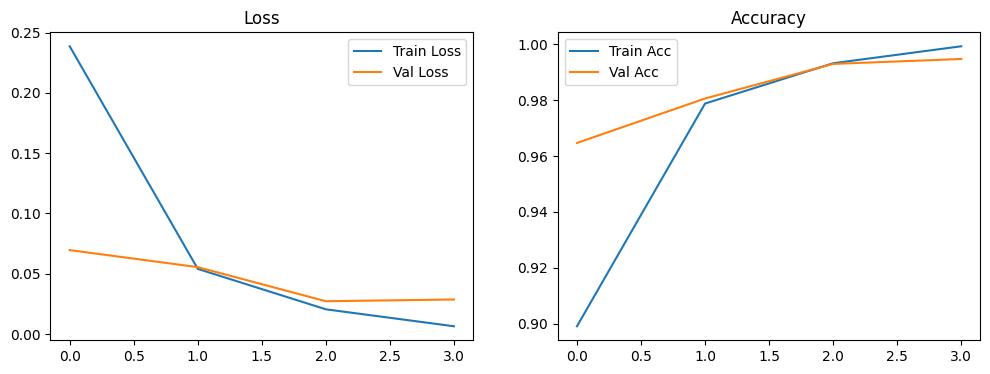

18/18 [==============================] - 6s 204ms/step
F1 Score: 0.9930
Recall: 0.9965
Precision: 0.9895
Confusion Matrix:
 [[280   3]
 [  1 282]]
Saving model to: llm_roberta_model_weights\llm_roberta_model_model
Saving tokenizer to: llm_roberta_model_weights\llm_roberta_model_tokenizer
Save configuration to: llm_roberta_model_weights\llm_roberta_model_config.json
RoBERTa Model, tokenizer and configuration stored under llm_roberta_model_weights. Finished Training!


In [16]:
if mode == ModelRunMode.TRAIN.value:
    # Check if Tensorflow is listing available GPUs (if not, continue with CPU)
    print("Tensorflow List of GPUs:", tf.config.list_physical_devices('GPU'))
    
    # Train model
    train_roberta(input_csv=input_csv, output_csv=output_csv, model_ckpt="roberta-base", output_dir=file_path, model_prefix=model_prefix, num_train_epochs=5, batch_size=32, test_size=test_size, learning_rate=5e-5, random_state=random_state)

if mode == ModelRunMode.CLASSIFY.value:
    # Classification
    classify_roberta(input_csv=input_csv, output_csv=output_csv, output_dir=file_path, separator_char=separator_char)